# Description

This code is an interactive version of Array2Corridors.py ; Its purpose is to help you understand the code and to troubleshoot it if needed by executing it step by step and visualizing the intermediate results.

## 1. Importing the necessary libraries and defining the paths used in the code

In [6]:
import cv2
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import more_itertools as mit
from pathlib import Path
import os
from scipy import signal
import holoviews as hv
from holoviews import opts

import re
from tqdm import tqdm
import subprocess

In [22]:
# Path definitions

inputfolder = Path("/home/matthias/Videos/Subset_Test2/")

## 2. Loading the data and preparing the data structures

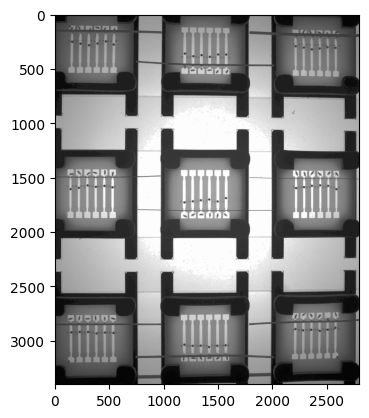

In [8]:
# Load the first frame

frame = cv2.imread(inputfolder.joinpath("image0.jpg").as_posix())

# make it grayscale
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# equalize the histogram to make thresholding easier
frame = cv2.equalizeHist(frame)

# rotate the image 90 degrees
frame = np.rot90(frame)

# display the frame
plt.figure()
plt.imshow(frame, cmap="gray", vmin=0, vmax=255)
plt.show()

## 3. Find the arenas in the image

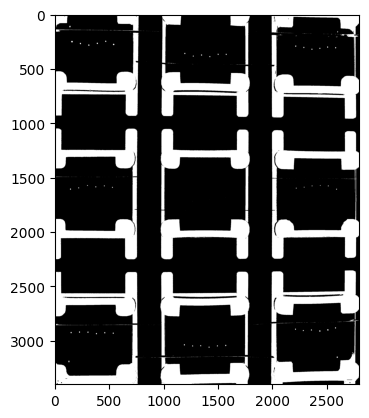

In [9]:
Thresh = frame.copy()
# Apply a threshold to the frame to keep only the pixels with a value < 20
Thresh[Thresh > 60] = 0
# For the pixels with a value < 20, set their value to 255
Thresh[Thresh > 0] = 255
# display the frame
plt.imshow(Thresh, cmap="gray", vmin=0, vmax=255)

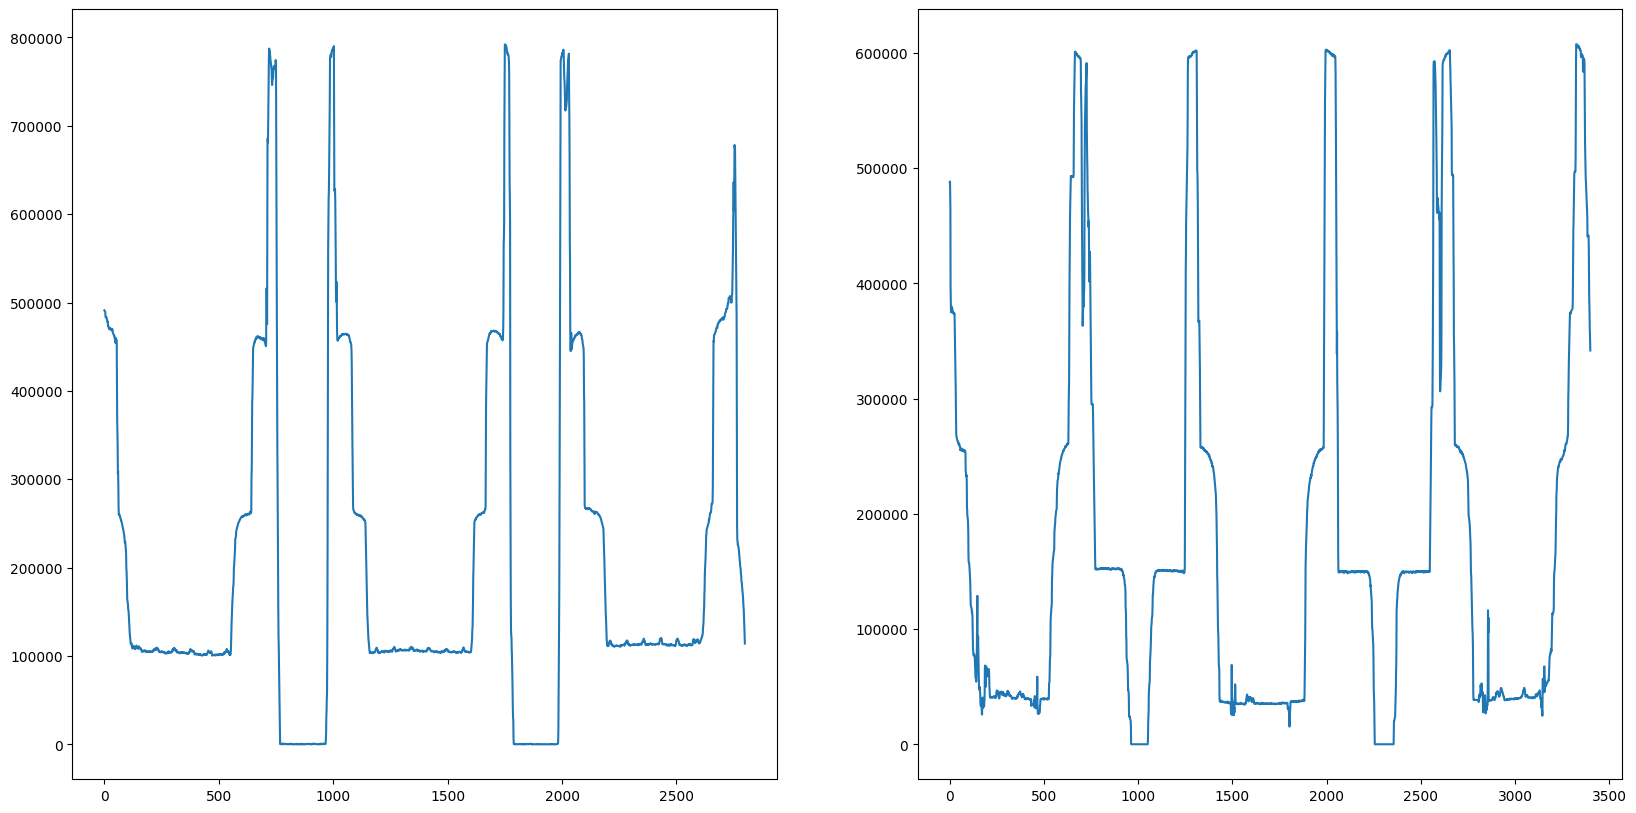

In [14]:
# Generate column and row sums

cols = Thresh.sum(axis=0)

rows = Thresh.sum(axis=1)

# Plot the column and row sums side by side

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(cols)
plt.subplot(1, 2, 2)
plt.plot(rows)
plt.show()


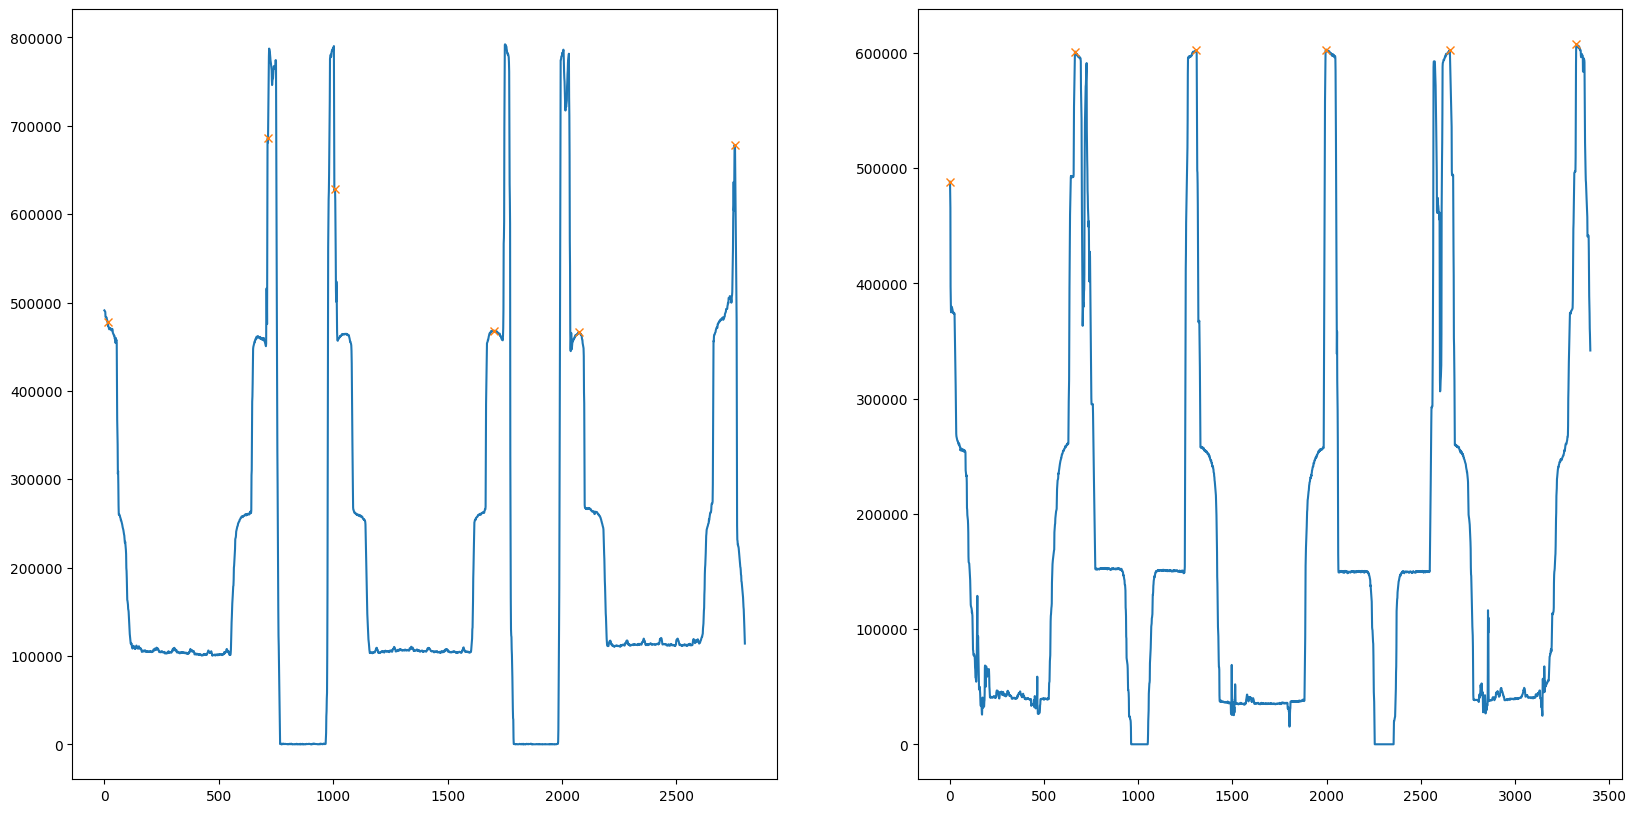

In [15]:
# Find arena edges as peaks in the column and row sums

colbounds = signal.find_peaks(
    cols,
    distance=200,
    height=(300_000, 700_000),
)

rowbounds = signal.find_peaks(
    rows,
    distance=200,
    height=(300_000, 700_000),
)

# Plot the column and row sums with the peaks

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(cols)
plt.plot(colbounds[0], cols[colbounds[0]], "x")
plt.subplot(1, 2, 2)
plt.plot(rows)
plt.plot(rowbounds[0], rows[rowbounds[0]], "x")
plt.show()


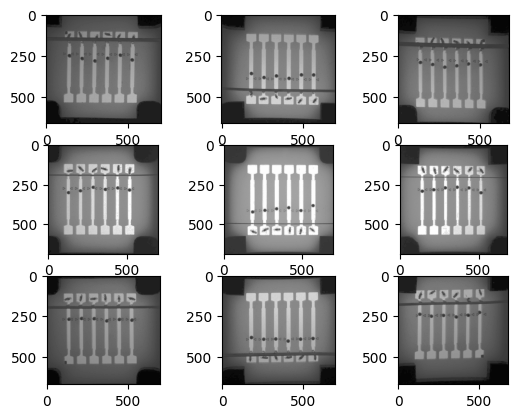

In [18]:
# Define and store the arena edges from the peaks locations
xcoords = colbounds[0]
ycoords = rowbounds[0]

regions_of_interest = [
    (xcoords[0], ycoords[0], xcoords[1], ycoords[1]),
    (xcoords[2], ycoords[0], xcoords[3], ycoords[1]),
    (xcoords[4], ycoords[0], xcoords[5], ycoords[1]),
    (xcoords[0], ycoords[2], xcoords[1], ycoords[3]),
    (xcoords[2], ycoords[2], xcoords[3], ycoords[3]),
    (xcoords[4], ycoords[2], xcoords[5], ycoords[3]),
    (xcoords[0], ycoords[4], xcoords[1], ycoords[5]),
    (xcoords[2], ycoords[4], xcoords[3], ycoords[5]),
    (xcoords[4], ycoords[4], xcoords[5], ycoords[5]),
]

# Plot the regions of interest on the frame

fig, axs = plt.subplots(3, 3)
for i, ax in enumerate(axs.flat):
    ax.imshow(
        frame[
            regions_of_interest[i][1] : regions_of_interest[i][3],
            regions_of_interest[i][0] : regions_of_interest[i][2],
        ],
        cmap="gray",
        vmin=0,
        vmax=255,
    )
plt.show()

In [19]:
# For each subset, find the cols and rows peaks and store the even peaks in a list
Corridors = []
for i in range(len(regions_of_interest)):
    subset = np.array(
        frame[
            regions_of_interest[i][1] : regions_of_interest[i][3],
            regions_of_interest[i][0] : regions_of_interest[i][2],
        ]
    )
    Thresh = subset.copy()
    # Apply an adaptive threshold to each subset to keep only the brightest pixels
    Thresh = cv2.adaptiveThreshold(
        Thresh, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 31, 4
    )

    cols = Thresh.sum(axis=0)
    rows = subset.sum(axis=1)

    colpeaks = signal.find_peaks(
        cols[100:620],
        distance=20,
        height=(60_000, 120_000),
        # width=(5, 30),
    )
    colpeaks = (colpeaks[0] + 100, colpeaks[1])

    rowpeaks = signal.find_peaks(
        rows,
        distance=300,
    )
    #######################################################
    Colpos = []
    Rowpos = []

    for peak_index in colpeaks[0]:
        peak_x = regions_of_interest[i][0] + peak_index
        peak_y = np.argmax(subset[peak_index])
        peak_y += regions_of_interest[i][1]
        Colpos.append((peak_x, peak_y))

    for peak_index in rowpeaks[0]:
        peak_x = np.argmax(subset[peak_index])
        peak_x += regions_of_interest[i][0]
        peak_y = regions_of_interest[i][1] + peak_index
        Rowpos.append((peak_x, peak_y))

    bound_x = 30
    bound_y = 50

    subcors = [
        (
            Colpos[0][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[1][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[2][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[3][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[4][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[5][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[6][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[7][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[8][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[9][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
        (
            Colpos[10][0] - bound_x,
            Rowpos[0][1] - bound_y,
            Colpos[11][0] + bound_x,
            Rowpos[1][1] + bound_y,
        ),
    ]

    # subcors = generate_subsets(subset, regions_of_interest)

    Corridors.append(subcors)

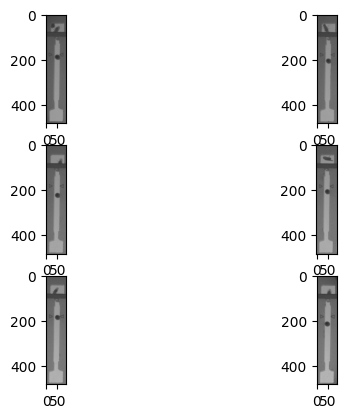

In [20]:
# As an example, display all the corridors from Corridors[0] in a grid based on the frame
fig, axs = plt.subplots(3, 2)
for i, ax in enumerate(axs.flat):
    ax.imshow(
        frame[
            Corridors[0][i][1] : Corridors[0][i][3],
            Corridors[0][i][0] : Corridors[0][i][2],
        ],
        cmap="gray",
        vmin=0,
        vmax=255,
    )

# 4. Use the generated coordinates to save corridor crops for each frame of the video

In [23]:
# Create a list of all the images in the Test2 folder
images = []
for filename in inputfolder.iterdir():
    images.append(filename.name)

# sort the list of images by their number
images.sort(key=lambda f: int(re.sub("\D", "", f)))

for i, image in tqdm(enumerate(images), total=len(images)):
    frame = cv2.imread(f"/home/matthias/Videos/Subset_Test2/{image}")
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = np.rot90(frame)

    for j, subset in enumerate(Corridors):
        for k, corridor in enumerate(subset):
            # Create the subfolder if it doesn't exist
            subfolder = f"/home/matthias/Videos/Subset_Test2_Cropped/arena{j+1}/corridor_{k+1}"
            os.makedirs(subfolder, exist_ok=True)

            # Crop the image
            x1, y1, x2, y2 = corridor
            cropped_image = frame[y1:y2, x1:x2]

            # Save the cropped image
            cropped_image_file = f"{os.path.splitext(image)[0]}_cropped.jpg"
            cv2.imwrite(os.path.join(subfolder, cropped_image_file), cropped_image)

100%|██████████| 14/14 [00:00<00:00, 22.81it/s]


In [ ]:
# Version forcing GrayScale

for i, image in tqdm(enumerate(images), total=len(images)):
    frame = cv2.imread(f"/home/matthias/Videos/Test2/{image}", cv2.IMREAD_GRAYSCALE)

    for j, subset in enumerate(Corridors):
        for k, corridor in enumerate(subset):
            # Create the subfolder if it doesn't exist
            subfolder = f"/home/matthias/Videos/Test2_subsets/arena{j+1}/corridor_{k+1}"
            os.makedirs(subfolder, exist_ok=True)

            # Crop the image
            x1, y1, x2, y2 = corridor
            cropped_image = frame[y1:y2, x1:x2]

            # Save the cropped image
            cropped_image_file = f"{os.path.splitext(image)[0]}_cropped.jpg"
            cv2.imwrite(os.path.join(subfolder, cropped_image_file), cropped_image)